In [1]:
#how to work out the data
what_were_covering = {1: "data (prepare and load)",
    2: "build model",
    3: "fitting the model to data (training)",
    4: "making predictions and evaluating a model (inference)",
    5: "saving and loading a model",
    6: "putting it all together"
}

Data preparing and loading

In [2]:
import torch
from torch import nn # nn contains all of PyTorch's building blocks for neural networks
import matplotlib.pyplot as plt

# Check PyTorch version
torch.__version__

'2.7.1+cu126'

In [3]:
# creat data
weight=0.7
bias=0.3
start=0
end=1
step=0.02
x=torch.arange(start,end,step).unsqueeze(dim=1)
y=weight*x+bias
x[:10],y[:10]

(tensor([[0.0000],
         [0.0200],
         [0.0400],
         [0.0600],
         [0.0800],
         [0.1000],
         [0.1200],
         [0.1400],
         [0.1600],
         [0.1800]]),
 tensor([[0.3000],
         [0.3140],
         [0.3280],
         [0.3420],
         [0.3560],
         [0.3700],
         [0.3840],
         [0.3980],
         [0.4120],
         [0.4260]]))

In [4]:
len(x),len(y)

(50, 50)

Split them into train val test

In [5]:
train_split=int(0.8*len(x))
x_train,y_train=x[:train_split],y[:train_split]
x_test,y_test=x[train_split:],y[train_split:]
x_train[:5],y_train[:5],x_test[:5],y_test[:5]

(tensor([[0.0000],
         [0.0200],
         [0.0400],
         [0.0600],
         [0.0800]]),
 tensor([[0.3000],
         [0.3140],
         [0.3280],
         [0.3420],
         [0.3560]]),
 tensor([[0.8000],
         [0.8200],
         [0.8400],
         [0.8600],
         [0.8800]]),
 tensor([[0.8600],
         [0.8740],
         [0.8880],
         [0.9020],
         [0.9160]]))

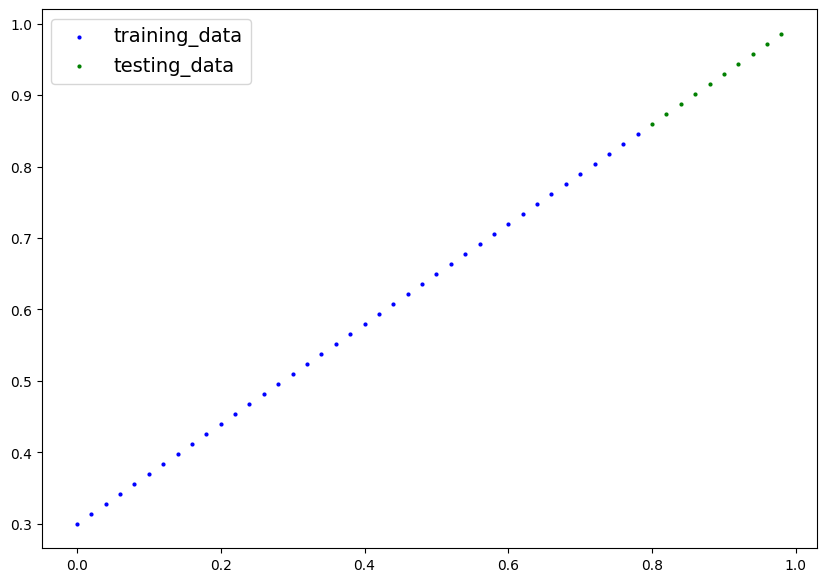

In [6]:
def plot_predictions(train_data=x_train,
                     train_labels=y_train,
                     test_data=x_test,
                     test_labels=y_test,
                     predictions=None):
    plt.figure(figsize=(10,7))
    plt.scatter(train_data,train_labels,c="b",s=4,label="training_data")
    plt.scatter(test_data,test_labels,c="g",s=4,label="testing_data")
    if predictions is not None:
        plt.scatter(test_data,predictions,c="r",s=4,label="predictions")
    plt.legend(prop={"size":14})
plot_predictions()

Build the first pytorch model

In [7]:
#create linear regression model class
from torch import nn
class LinearRegressionModel(nn.Module):
    def __init__(self):
        super().__init__()
        self.weights=nn.Parameter(torch.randn(1,
                                              requires_grad=True,
                                              dtype=torch.float))
        self.bias=nn.Parameter(torch.randn(1,
                                           requires_grad=True,
                                           dtype=torch.float))
    def forward(self, x):
        return self.weights * x + self.bias

    

PyTorch module	What does it do?

torch.nn	Contains all of the building blocks for computational graphs (essentially a series of computations executed in a particular way).

torch.nn.Parameter	Stores tensors that can be used with nn.Module. If requires_grad=True gradients (used for updating model parameters via gradient descent) are calculated automatically, this is often referred to as "autograd".

torch.nn.Module	The base class for all neural network modules, all the building blocks for neural networks are subclasses. If you're building a neural network in PyTorch, your models should subclass nn.Module. Requires a forward() method be implemented.

torch.optim	Contains various optimization algorithms (these tell the model parameters stored in nn.Parameter how to best change to improve gradient descent and in turn reduce the loss).

def forward()	All nn.Module subclasses require a forward() method, this defines the computation that will take place on the data passed to the particular nn.Module (e.g. the linear regression formula above).

In [8]:
torch.manual_seed(42)
model_0=LinearRegressionModel()
#CHECK out the parameters
model_0,list(model_0.parameters())

(LinearRegressionModel(),
 [Parameter containing:
  tensor([0.3367], requires_grad=True),
  Parameter containing:
  tensor([0.1288], requires_grad=True)])

In [9]:
#list name parameters
model_0.state_dict()

OrderedDict([('weights', tensor([0.3367])), ('bias', tensor([0.1288]))])

In [10]:
weight,bias

(0.7, 0.3)

In [11]:
### make predictions using torch.inference_mode()
with torch.inference_mode():
    y_preds=model_0(x_test)
y_preds

tensor([[0.3982],
        [0.4049],
        [0.4116],
        [0.4184],
        [0.4251],
        [0.4318],
        [0.4386],
        [0.4453],
        [0.4520],
        [0.4588]])

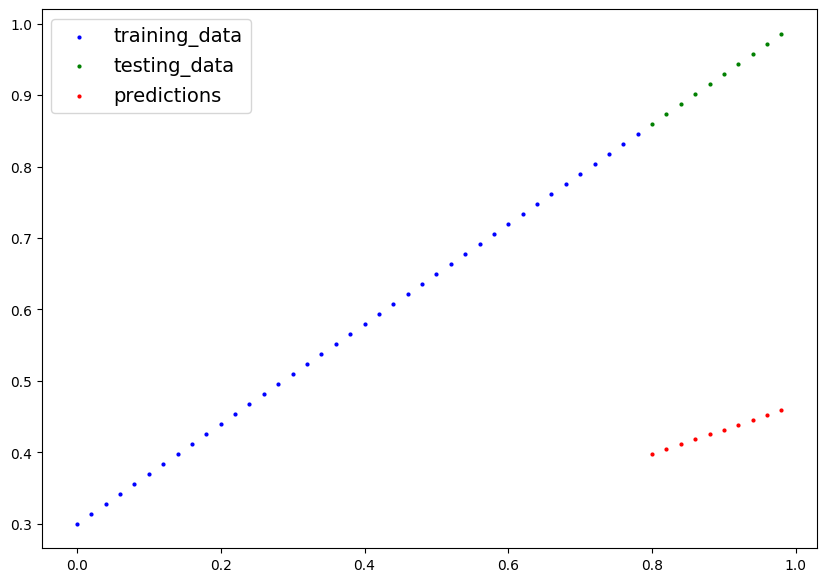

In [12]:
def plot_predictions(train_data=x_train,
                     train_labels=y_train,
                     test_data=x_test,
                     test_labels=y_test,
                     predictions=y_preds):
    plt.figure(figsize=(10,7))
    plt.scatter(train_data,train_labels,c="b",s=4,label="training_data")
    plt.scatter(test_data,test_labels,c="g",s=4,label="testing_data")
    if predictions is not None:
        plt.scatter(test_data,predictions,c="r",s=4,label="predictions")
    plt.legend(prop={"size":14})
plot_predictions()

In [13]:
with torch.no_grad():
    y_preds=model_0(x_test)
y_preds

tensor([[0.3982],
        [0.4049],
        [0.4116],
        [0.4184],
        [0.4251],
        [0.4318],
        [0.4386],
        [0.4453],
        [0.4520],
        [0.4588]])

In [14]:
with torch.no_grad():
    list(model_0.parameters())

#### Train the model
use the loss function
and use the optimizer

In [15]:
loss_fn=nn.L1Loss()
optimizer=torch.optim.SGD(params=model_0.parameters(),lr=0.01)

Build a training loop in pytorch

In [16]:
from tqdm import tqdm
epochs=200
epoch_count=[]
loss_values=[]
test_loss_values=[]
for epoch in tqdm(range(epochs)):
    model_0.train()
    y_pred=model_0(x_train)
    loss=loss_fn(y_pred,y_train)
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    model_0.eval()#关闭掉其他的东西
    with torch.inference_mode():#禁止了梯度追踪
        test_pred=model_0(x_test)
        test_loss=loss_fn(test_pred,y_test)
    if epoch%10==0:
        epoch_count.append(epoch)
        loss_values.append(loss.detach().numpy())
        test_loss_values.append(test_loss.detach().numpy())
        print(f"Epoch:{epoch} | Loss:{loss} | Test loss:{test_loss}")

  0%|          | 0/200 [00:00<?, ?it/s]

 54%|█████▍    | 108/200 [00:00<00:00, 606.10it/s]

Epoch:0 | Loss:0.31288138031959534 | Test loss:0.48106518387794495
Epoch:10 | Loss:0.1976713240146637 | Test loss:0.3463551998138428
Epoch:20 | Loss:0.08908725529909134 | Test loss:0.21729660034179688
Epoch:30 | Loss:0.053148526698350906 | Test loss:0.14464017748832703
Epoch:40 | Loss:0.04543796554207802 | Test loss:0.11360953003168106
Epoch:50 | Loss:0.04167863354086876 | Test loss:0.09919948130846024
Epoch:60 | Loss:0.03818932920694351 | Test loss:0.08886633068323135
Epoch:70 | Loss:0.03476089984178543 | Test loss:0.0805937647819519
Epoch:80 | Loss:0.03132382780313492 | Test loss:0.07232122868299484
Epoch:90 | Loss:0.02788739837706089 | Test loss:0.06473556160926819
Epoch:100 | Loss:0.024458957836031914 | Test loss:0.05646304413676262
Epoch:110 | Loss:0.021020207554101944 | Test loss:0.04819049686193466
Epoch:120 | Loss:0.01758546568453312 | Test loss:0.04060482233762741
Epoch:130 | Loss:0.014155393466353416 | Test loss:0.03233227878808975
Epoch:140 | Loss:0.010716589167714119 | Test

100%|██████████| 200/200 [00:00<00:00, 564.95it/s]

Epoch:180 | Loss:0.008932482451200485 | Test loss:0.005023092031478882
Epoch:190 | Loss:0.008932482451200485 | Test loss:0.005023092031478882


In [17]:
y_preds=model_0(x_test).detach().numpy() 

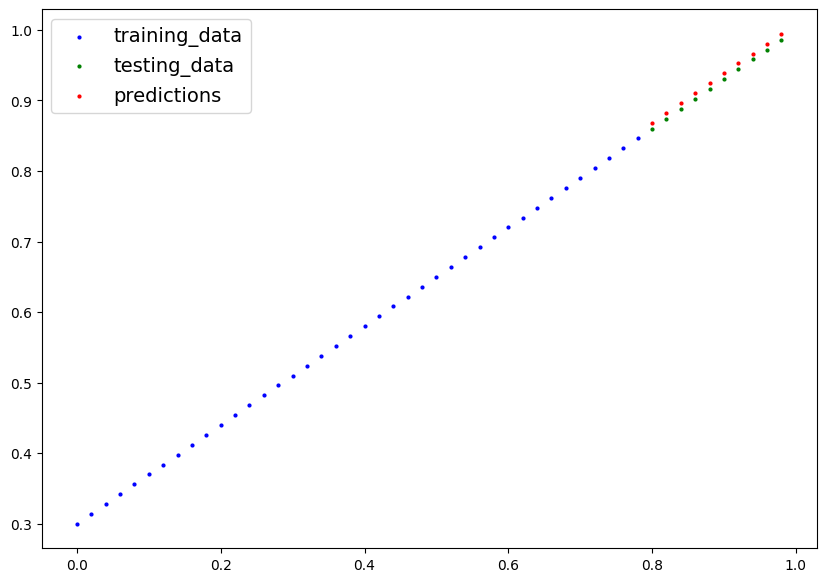

In [18]:
def plot_predictions(train_data=x_train,
                     train_labels=y_train,
                     test_data=x_test,
                     test_labels=y_test,
                     predictions=y_preds):
    plt.figure(figsize=(10,7))
    plt.scatter(train_data,train_labels,c="b",s=4,label="training_data")
    plt.scatter(test_data,test_labels,c="g",s=4,label="testing_data")
    if predictions is not None:
        plt.scatter(test_data,predictions,c="r",s=4,label="predictions")
    plt.legend(prop={"size":14})
plot_predictions()

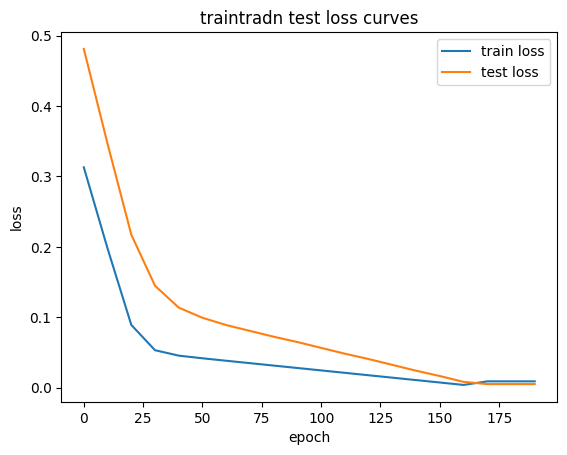

In [19]:
plt.plot(epoch_count,loss_values,label="train loss")
plt.plot(epoch_count,test_loss_values,label="test loss")
plt.title("traintradn test loss curves")
plt.ylabel("loss")
plt.xlabel("epoch")
plt.legend()

In [26]:
#saving a model in pytorch
#pickle
from pathlib import Path
path=Path("model_parameters")
path.mkdir(parents=True,exist_ok=True)
model_name="model_0.pth"
model_save_path=path/model_name
torch.save(model_0.state_dict(),model_save_path)

In [31]:
model_1=LinearRegressionModel() 
model_1.load_state_dict(torch.load(f=model_save_path))



<All keys matched successfully>

In [32]:
#make predictions
model_1.eval()
with torch.inference_mode():
    model_1_preds=model_1(x_test)
model_1_preds
    

tensor([[0.8685],
        [0.8825],
        [0.8965],
        [0.9105],
        [0.9245],
        [0.9384],
        [0.9524],
        [0.9664],
        [0.9804],
        [0.9944]])

In [33]:
print(model_1_preds==y_preds)

tensor([[True],
        [True],
        [True],
        [True],
        [True],
        [True],
        [True],
        [True],
        [True],
        [True]])
